In [19]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.datasets import mnist
import numpy as np

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

# Load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize pixel values
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
print(x_train.shape)
x_train = np.expand_dims(x_train, -1)
print(x_train.shape)
x_test = np.expand_dims(x_test, -1)

# VAE model
class VAE(Model):
    latent_dim = 20
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(28, 28, 1)),
            layers.Conv2D(32, 3, activation='relu', strides=2, padding='same'),
            layers.Conv2D(64, 3, activation='relu', strides=2, padding='same'),
            layers.Flatten()
        ])
        
        self.bottleneck_mean = tf.keras.Sequential([
            layers.Input(shape=(64*7*7)),
            layers.Dense(self.latent_dim, activation='relu') # assuming 20-dimensional latent space
        ])
        
        self.bottleneck_logvar = tf.keras.Sequential([
            layers.Input(shape=(64*7*7)),
            layers.Dense(self.latent_dim,activation='relu')
        ])
        
        self.decoder = tf.keras.Sequential([
            layers.Input(shape=(self.latent_dim,)),
            layers.Dense(7*7*64, activation='relu'),
            layers.Reshape((7, 7, 64)),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(32, 3, activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(1, 3, activation='sigmoid', padding='same')
        ])

    def call(self, x):
        z_mean, z_logvar = self.encode(x)
        z = self.reparameterize(z_mean, z_logvar)
        reconstructed = self.decoder(z)
        return reconstructed, z_mean, z_logvar

    def reparameterize(self, mean, log_var):
        batch_size = tf.shape(mean)[0]
        epsilon = tf.random.normal(shape=(batch_size, tf.shape(mean)[1]))
        return mean + tf.exp(0.5 * log_var) * epsilon
    
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        x = self.encoder(x)
        mean = self.bottleneck_mean(x)
        logvar = self.bottleneck_logvar(x)
        return mean, logvar

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits
    # Training step
    def train_step(self,data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            z_mean, z_logvar = self.encode(inputs)
            z = self.reparameterize(z_mean,z_logvar)
            reconstructed = self.decode(z)
            reconstruction_loss = tf.reduce_sum(binary_crossentropy(targets, reconstructed)*28*28, axis=[1,2])
            kl_loss = -0.5*tf.reduce_sum(1 + z_logvar - tf.square(z_mean) - tf.exp(z_logvar), axis=-1)
            loss = tf.reduce_mean(reconstruction_loss + kl_loss)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        # Log the loss
        loss_dict = {'loss': loss}
        return loss_dict
        
        
# Instantiate the model and optimizer
vae = VAE()
optimizer = tf.keras.optimizers.Adam()


(60000, 28, 28)
(60000, 28, 28, 1)


In [20]:
# Compile the model with your custom loss function
vae.compile(optimizer=tf.optimizers.RMSprop(1e-3))

# Train the model
history = vae.fit(x_train,x_train, epochs=2)

# Evaluate performance on test set
test_loss = vae.evaluate(x_test,x_test)
print("Test loss:", test_loss)

Epoch 1/2
1875/1875 [==============================] - 32s 16ms/step - loss: 85011.2813
Epoch 2/2
313/313 [==============================] - 2s 5ms/step - loss: 0.0000e+00
Test loss: 0.0


In [28]:

# Training loop
epochs = 10
batch_size = 128
for epoch in range(epochs):
    print("\nStart of epoch", epoch + 1)
    for step in range(len(x_train) // batch_size):
        batch_images = x_train[step * batch_size : (step + 1) * batch_size]
        loss = vae.train_step((batch_images, batch_images))['loss']
        if step % 100 == 0:
            print("Step", step, "Loss:", float(loss))


Start of epoch 1
Step 0 Loss: 59037.5390625
Step 100 Loss: 66077.71875
Step 200 Loss: 66179.4609375
Step 300 Loss: 62483.26171875
Step 400 Loss: 62967.46875

Start of epoch 2
Step 0 Loss: 62464.87890625
Step 100 Loss: 66286.8125
Step 200 Loss: 66248.078125
Step 300 Loss: 60716.1640625
Step 400 Loss: 62923.92578125


KeyboardInterrupt: 

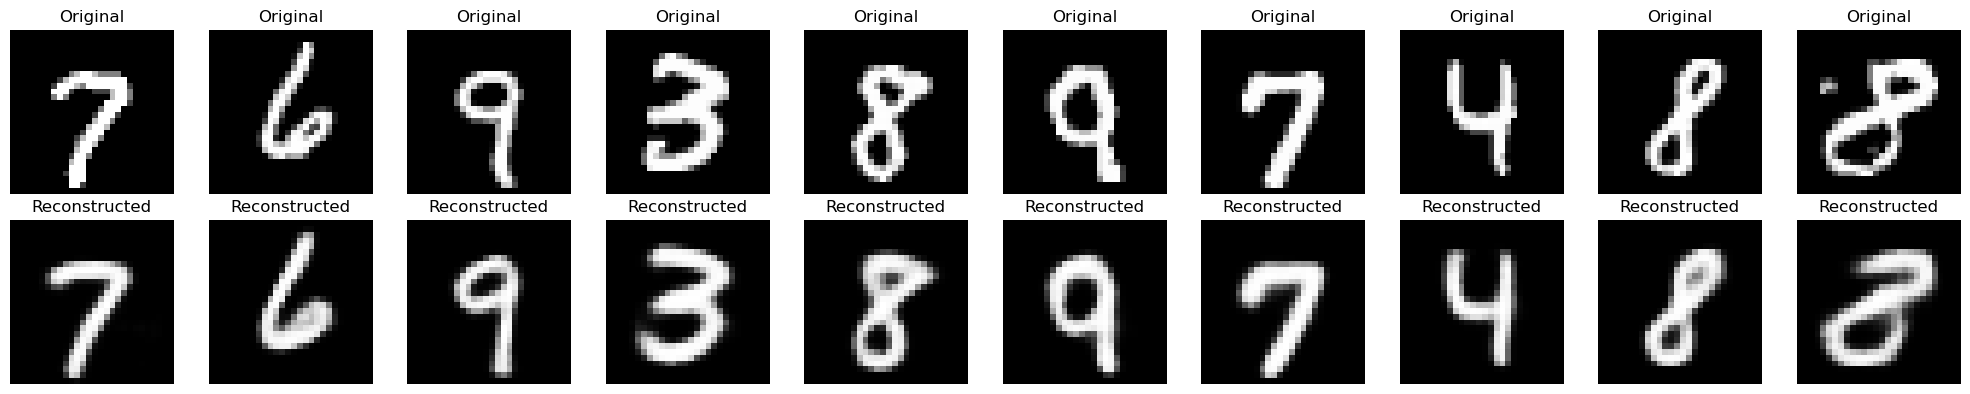

In [29]:
import matplotlib.pyplot as plt

# Select a few samples from the test set
num_samples = 10
sample_indices = np.random.choice(len(x_test), num_samples, replace=False)
test_samples = x_test[sample_indices]

# Generate reconstructions using the VAE
reconstructed_samples, _, _ = vae(test_samples)

# Plot original images and reconstructions
plt.figure(figsize=(num_samples * 2, 4))
for i in range(num_samples):
    # Plot original images
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(test_samples[i].squeeze(), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Plot reconstructed images
    plt.subplot(2, num_samples, i + 1 + num_samples)
    plt.imshow(reconstructed_samples[i].numpy().squeeze(), cmap='gray')
    plt.title('Reconstructed')
    plt.axis('off')

plt.tight_layout()
plt.show()
